In [1]:
# notebook to obtain results for Figure B1 of https://arxiv.org/pdf/2508.05390

In [2]:
from pytket.extensions.qiskit import AerStateBackend
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import hamming

In [ ]:
def construct_single_excitation_operators(reference):
    """
    Function to return a list of reference-state-specific occupied-to-virtual single excitations conserving azimuthal spin.
    
    In InQuanto, these excitations are represented by FermionOperator object, see https://docs.quantinuum.com/inquanto/api/inquanto/operators.html#inquanto.operators.FermionOperator.

    Each item in the returned list of excitations should have a method to apply the operator to a ket respresenting an occupation configuration. 
    - see https://docs.quantinuum.com/inquanto/api/inquanto/operators.html#inquanto.operators.FermionOperator.apply_ket
    """
    pass

def construct_double_excitation_operators(reference):
    """
    Function to return a list of occupied-to-virtual double excitations conserving azimuthal spin.

    Corresponds to a_p^ a_q a_r^ a_s where p q r s are spin orbital indexes. 
    
    In InQuanto, these excitations are represented by FermionOperator object, see https://docs.quantinuum.com/inquanto/api/inquanto/operators.html#inquanto.operators.FermionOperator.

    Each item in the returned list of excitations should have a method to apply the operator to a ket respresenting an occupation configuration. 
    - see https://docs.quantinuum.com/inquanto/api/inquanto/operators.html#inquanto.operators.FermionOperator.apply_ket
    
    """
    pass

def run_vqe():
    """
    Function to perform a variational quantum eigensolver simulation, which can use random initial parameters. Can be state-vector-only. 
    - see https://docs.quantinuum.com/inquanto/api/inquanto/express.html#inquanto.express.run_vqe

    Requires ansatz and hamiltonian objects.

    Note in InQuanto, conversion of hamiltonian dataframe to an Operator object (e.g. InQuanto's QubitOperator) is required. 
    - For information on QubitOperator see https://docs.quantinuum.com/inquanto/api/inquanto/operators.html#inquanto.operators.QubitOperator

    Returns an object (vqe) containing VQE information as attributes
    - vqe.final_value: optimized value of the objective function
    - vqe.final_parameters: an object (e.g. dictionary) mapping ansatz parameter symbols to optimized parameter values.
    """
    pass


class FermionSpaceAnsatzUCCSD(reference):
    """ 
    Class to build Unitary coupled cluster with singles and doubles excitations (UCCSD), instantiated from a reference which specifies spin orbital occupations.
    
    Should have a method like circuit_resources to return circuit resource estimates.
     - see https://docs.quantinuum.com/inquanto/api/inquanto/ansatz.html#inquanto.ansatzes.GeneralAnsatz.circuit_resources

    Should have a method to convert to an InQuanto CircuitAnsatz object. 
    - see https://docs.quantinuum.com/inquanto/api/inquanto/ansatz.html#inquanto.ansatzes.GeneralAnsatz.to_CircuitAnsatz
     
    """ 
    def __init__(reference):
        pass
    
    def circuit_resources():
        pass

    def to_CircuitAnsatz():
        pass
    
    pass


class MultiConfigurationState():
    """ 
    Class to build an non-symbolic ansatz object specifying a selected linear combination of occupation configurations.

    Instantiated from a QubitState (dictionary-like object storing configurations and coefficients of a state vector).

    This is the GR method, using externally controlled Given's rotations.
    
    Should have a method to return a non-symbolic circuit representing the state vector
    - see https://docs.quantinuum.com/inquanto/api/inquanto/ansatz.html#inquanto.ansatzes.GeneralAnsatz.get_circuit

    See https://docs.quantinuum.com/inquanto/api/inquanto/ansatz.html#inquanto.ansatzes.MultiConfigurationState.

    """
    def __init__(QubitState):
        pass

    def get_circuit():
        pass

    pass


class MultiConfigurationStateSparse():
    """ 
    Class to build an non-symbolic ansatz object specifying a selected linear combination of occupation configurations.

    Instantiated from a QubitState (dictionary-like object storing configurations and coefficients of a state vector).

    This is the SSP method, based on Gleinig and Hoefler’s 2021 IEEE paper https://ieeexplore.ieee.org/document/9586240.

    Should have a method to return a non-symbolic circuit representing the state vector
    - see https://docs.quantinuum.com/inquanto/api/inquanto/ansatz.html#inquanto.ansatzes.GeneralAnsatz.get_circuit

    See https://docs.quantinuum.com/inquanto/api/inquanto/ansatz.html#inquanto.ansatzes.MultiConfigurationStateSparse.

    """
    def __init__(QubitState):
        pass

    def get_circuit():
        pass
    
    pass


class QubitMappingJordanWigner():
    """
    Class representing the mapping from fermions to qubits using the Jordan-Wigner transformation.

    See https://docs.quantinuum.com/inquanto/api/inquanto/mappings.html#inquanto.mappings.QubitMappingJordanWigner
    """
    pass

In [3]:
jw_map = QubitMappingJordanWigner()

backend = AerStateBackend()

angles_list = [0, 20, 40, 60, 80, 90, 100, 120, 140, 160, 180]
qubit_hams = []
for i in angles_list:
    ham = pandas.read_csv(f"hams/ham_c2h4_4qubit_angle{i}.csv")
    # print(f"angle={i}, csv ham:\n", ham)
    qubit_hams.append(ham)

qubit_hamiltonian = qubit_hams[5]

hf_state = [1, 1, 0, 0]

uccsd = FermionSpaceAnsatzUCCSD(hf_state)

vqe = run_vqe(uccsd, qubit_hamiltonian, backend=backend)
energy = vqe.final_value
gs_ansatz = uccsd.to_CircuitAnsatz(vqe.final_parameters)

U_circ = gs_ansatz.get_circuit(vqe.final_parameters)  # https://docs.quantinuum.com/inquanto/api/inquanto/ansatz.html#inquanto.ansatzes.CircuitAnsatz.get_circuit
U_circ_comp = AerStateBackend().get_compiled_circuit(U_circ, optimisation_level=1)
print(f'Utheta_circ total, 2qb: {U_circ_comp.n_gates, U_circ_comp.n_2qb_gates()}')
print(f' VQE en: {energy}')

# TIMER BLOCK-0 BEGINS AT 2025-09-02 15:20:26.919199
# TIMER BLOCK-0 ENDS - DURATION (s):  0.0671053 [0:00:00.067105]
Utheta_circ total, 2qb: (73, 40)
 VQE en: -76.97692960591576


In [4]:
def excited_reference_states(t):
    reference_qubit_states = []
    reference_fermion_states = []
    for excitation_operator, _ in t.items():
        excited_state = excitation_operator.apply_ket(hf_state)
        reference_qubit_states.append(jw_map.state_map(excited_state))
        reference_fermion_states.append(excited_state)
    return reference_fermion_states, reference_qubit_states

excitation_operators = construct_single_excitation_operators(hf_state)
excitation_operators += construct_double_excitation_operators(hf_state)

ops = excitation_operators

fm_exc_states, qb_exc_states = excited_reference_states(ops)

n_expansion_operators = len(excitation_operators)

In [5]:
def get_m_mat(version):
    M_2qb = np.zeros((n_expansion_operators, n_expansion_operators))

    M_total = np.zeros((n_expansion_operators, n_expansion_operators))
    
    for i, si in enumerate(qb_exc_states):
        state_i = gs_ansatz.copy().reset_reference(si)  # Resetting reference state, see https://docs.quantinuum.com/inquanto/api/inquanto/ansatz.html#inquanto.ansatzes.GeneralAnsatz.reset_reference
        cc = state_i.get_circuit()  # https://docs.quantinuum.com/inquanto/api/inquanto/ansatz.html#inquanto.ansatzes.CircuitAnsatz.get_circuit
        cc_comp = AerStateBackend().get_compiled_circuit(cc, optimisation_level=1)    
        M_total[i,i] = cc_comp.n_gates
        M_2qb[i, i] = cc_comp.n_2qb_gates()

    for i, si in enumerate(qb_exc_states):
        for j, sj in enumerate(qb_exc_states):
            if i > j:
                linear_combination_si_sj = np.sqrt(0.5) * (si + sj)
                if version == 'sparse':
                    comb_state = gs_ansatz.copy().reset_reference(MultiConfigurationStateSparse(linear_combination_si_sj).get_circuit())
                elif version == 'state':
                    comb_state = gs_ansatz.copy().reset_reference(MultiConfigurationState(linear_combination_si_sj).get_circuit())
                cc = comb_state.get_circuit()
                cc_comp = AerStateBackend().get_compiled_circuit(cc, optimisation_level=1) 
                M_total[i,j] = cc_comp.n_gates
                M_2qb[i,j] = cc_comp.n_2qb_gates()
                M_total[j,i] = M_total[i,j]
                M_2qb[j,i] = M_2qb[i,j]

    return M_total, M_2qb

In [6]:
M_total, M_2qb = get_m_mat('state')
M_total_sparse, M_2qb_sparse = get_m_mat('sparse')

In [8]:
labels = []
for i in range(n_expansion_operators):
    fm_string = fm_exc_states[i].single_term
    tmp = list(fm_string.values())
    labels.append(tmp)

indi = 0
ham_mat = np.zeros((n_expansion_operators, n_expansion_operators))
count = 0
for statei in labels:
    indj = 0
    for statej in labels:    
        tmp = hamming(statei, statej) * fock_space.n_spin_orb
        ham_mat[indi, indj] = tmp
        indj = indj + 1
        count = tmp + count
    indi = indi + 1

/var/folders/yv/qzf425mj63ngl4ypmn2w327c0000gn/T/ipykernel_10250/3132360687.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels, rotation=45, ha='left')
/var/folders/yv/qzf425mj63ngl4ypmn2w327c0000gn/T/ipykernel_10250/3132360687.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels, rotation=45, ha='left')
/var/folders/yv/qzf425mj63ngl4ypmn2w327c0000gn/T/ipykernel_10250/3132360687.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels, rotation=45, ha='left')


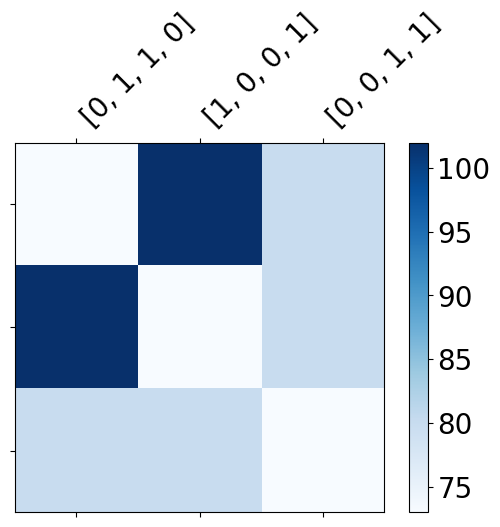

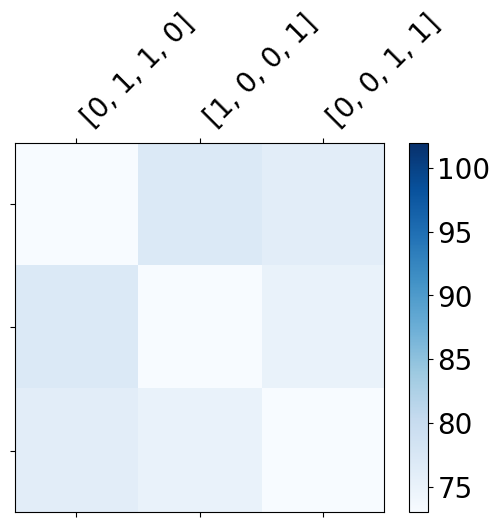

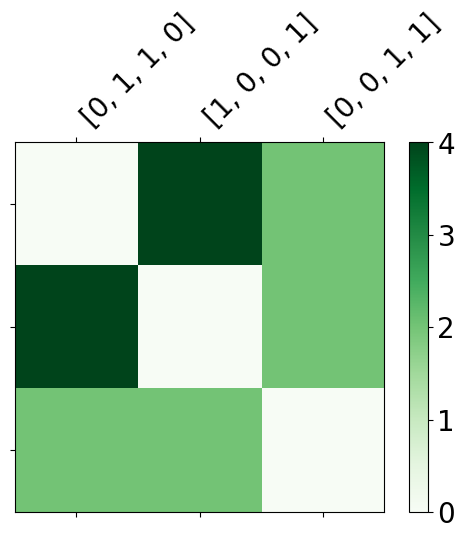

[[ 73. 102.  80.]
 [102.  73.  80.]
 [ 80.  80.  73.]]
----
[[73. 77. 76.]
 [77. 73. 75.]
 [76. 75. 73.]]
[[40. 54. 44.]
 [54. 40. 44.]
 [44. 44. 40.]]
----
[[40. 43. 41.]
 [43. 40. 41.]
 [41. 41. 40.]]
----


In [9]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
cmap = plt.cm.Blues
matrix = M_total
minG = np.min(matrix)
maxG = np.max(matrix)
im = ax.matshow(matrix, cmap=cmap, vmin=minG, vmax=maxG)
ax.set_xticklabels([''] + labels, rotation=45, ha='left')
plt.setp(ax.get_yticklabels(), visible=False)
fig.colorbar(im)

fig, ax = plt.subplots()
matrix = M_total_sparse
minG = np.min(M_total)
maxG = np.max(M_total)
im = ax.matshow(matrix, cmap=cmap, vmin=minG, vmax=maxG)
ax.set_xticklabels([''] + labels, rotation=45, ha='left')
plt.setp(ax.get_yticklabels(), visible=False)
fig.colorbar(im)

fig, ax = plt.subplots()
cmap = plt.cm.Greens
matrix = ham_mat
minG = np.min(matrix)
maxG = np.max(matrix)
im = ax.matshow(matrix, cmap=cmap, vmin=minG, vmax=maxG)
ax.set_xticklabels([''] + labels, rotation=45, ha='left')
plt.setp(ax.get_yticklabels(), visible=False)
fig.colorbar(im)

plt.show()

print(M_total)
print('----')
print(M_total_sparse)
print('===============')
print(M_2qb)
print('----')
print(M_2qb_sparse)
print('----')
